In this notebook I will run through an example of using the decoder to perform effective measurements and loss-tolerant teleportation of graph states. As an example lets consider the 5 qubit ring as our graph

In [1]:
from graphs import draw_graph, gen_ring_graph
from decoder_class import CascadeDecoder
import numpy as np
import matplotlib.pyplot as plt
from random import random

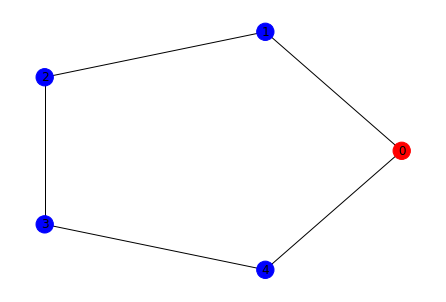

In [2]:
g = gen_ring_graph(5)
draw_graph(g)

Now initialise a decoder object that will calculate the properties of this graph.
Given a set of lost qubits and a set of measurements performed, the decoder will try to fidn the best measurement strategy that enables loss-tolerant teleportation of effective measurement.
Run a single iteration of the teleportation procedure with a capture probability of 0.8

In [3]:
r5 = CascadeDecoder(g)
result = r5.decode(mc=True, p=0.8, first_traversal=True)
lt_success, success_pattern, pauli_done, arb_meas, q_lost, counter, ec_checks_done, indirect_meas_ix = result

In [4]:
print(success_pattern)
print(pauli_done.to_str())
print(lt_success)
print(r5.strat.t)

[1, 1, 1]
Z1_Z3
True
4


We can repeat this procedure many times to do a monte-carlo simulation of the graphs loss-tolerance abilities.
An alternative strategy is to note that the decoder choices are deterministic, such that for any sequences of successful and failed measurements, it will always try the same strategy. We can explore every possibility, and find the probability of each to find the overall analytic success probability of the graph.
This is done with the build_tree() method.


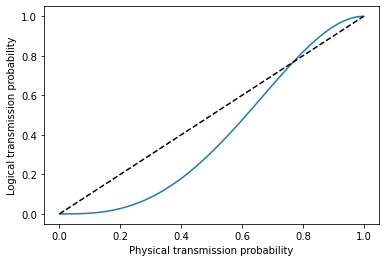

In [5]:
r5.build_tree(basis='spc', printing=False)
transmissions = np.linspace(0.001, 0.999)
logical_transmission = [r5.success_prob_outcome_list(t, depolarizing_noise=0, ec=False) for t in transmissions]
plt.plot(transmissions, logical_transmission)
plt.plot((0, 1), (0, 1), 'k--')
plt.xlabel('Physical transmission probability')
plt.ylabel('Logical transmission probability')
plt.show()

This can also be done for other measurement bases, for effective measurements in the X, Y or Z bases.


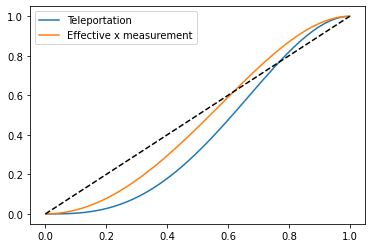

In [6]:
b = 'x'
r5.build_tree(basis=b)
plt.plot(transmissions, logical_transmission)
plt.plot(transmissions, [r5.success_prob_outcome_list(t, depolarizing_noise=0, basis=b, ec=False) for t in transmissions])
plt.legend([ 'Teleportation', f'Effective {b} measurement'])
plt.plot((0, 1), (0, 1), 'k--')
plt.show()

This decoder can also be used to find the next measurement to attempt for a given bit string of measurements
Build the decision tree for all possible basis measurements. We use the flag print_status=True to see the status of the decoder after this success pattern

In [7]:
for basis in ['spc', 'x', 'y', 'z', 'xy']:
    r5.build_tree(basis=basis, ec=True, cascading=False)
print(r5.next_measurement([1, 1], 'spc', cascading=False, print_status=True, ec=True))

Status:
    Lost qubits: []
    Qubits measured in arb basis: [4]
    Pauli measurements performed: Z1
self.success_pattern=[1, 1]
self.lt_finished=False
self.target_pauli.to_str()='Z1_Z3'
self.indirect_meas_ixs=[]
(3, 'z', False, None, None, None)


In this manner we can perform monte-carlo simulations outside of the decoder, for example for a simple loss tolerance protocol with stochastic errors at rate 0.1


In [8]:
def run_decoder_external(t, basis='spc'):
    lt_decoder_finished = False
    lt_decoder_succeeded = False
    qubit_measurement_successes = []
    measurements_done = []
    while not lt_decoder_finished:
        qubit_to_measure, next_basis, lt_decoder_finished, lt_decoder_succeeded,\
        ec_checks_done, ec_finished = r5.next_measurement(qubit_measurement_successes, decoder_type=basis, ec=False)
        if not lt_decoder_finished:
            outcome = int(random() < t)

            qubit_measurement_successes.append(outcome)
            if outcome:
                measurements_done.append(next_basis+str(qubit_to_measure))
    return lt_decoder_succeeded, measurements_done, qubit_measurement_successes

lt_succ, meas_done, q_successes = run_decoder_external(0.9, basis='spc')
print(f'{lt_succ=}')
print(f'{meas_done=}')
print(f'{q_successes=}')



lt_succ=True
meas_done=['a4', 'z1', 'z3']
q_successes=[1, 1, 1]


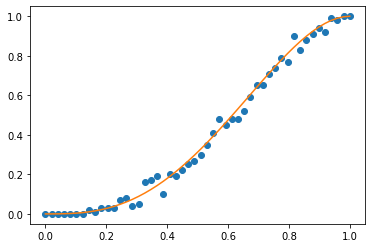

In [9]:
def mc_external(n_trials, t, basis='spc'):
    tot_wins = 0
    for _ in range(n_trials):
        lt_succ, meas_done, q_successes = run_decoder_external(t, basis=basis)
        if lt_succ:
            tot_wins += 1
    return tot_wins/n_trials

mc_probs = [mc_external(100, trans) for trans in transmissions]
plt.plot(transmissions, mc_probs, 'o')
plt.plot(transmissions, logical_transmission)
plt.show()

We can also incorporate error detection and mitigation in to this scheme.
This is done by continuing to decode after teleportation/effective measurements have been achieved, by measuring the remaining qubits in pauli bases such that we measure stabilizers that overlap with the target measurements.
We can inspect how the successful error detection rates vary with transmission and the degree of noise.
Consider depolarising noise, where we pick from errors in (I, X, Y, Z). Lets choose a graph with error tolerance.
Note that here we are ignoring errors on input and output qubits (this can be amended straightforwardly).

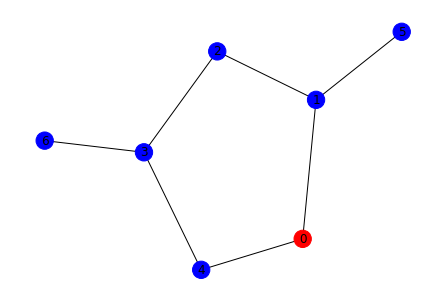

In [10]:
g2 = gen_ring_graph(5)
g2.add_edges_from([(1, 5), (3, 6)])
draw_graph(g2)


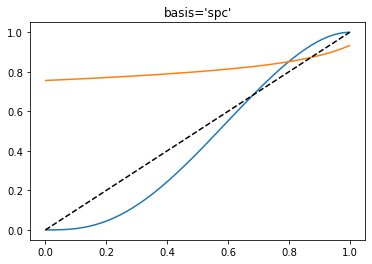

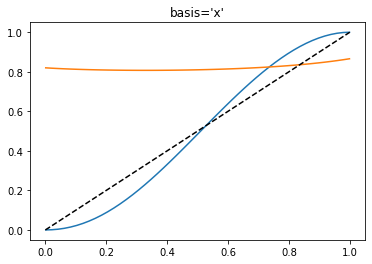

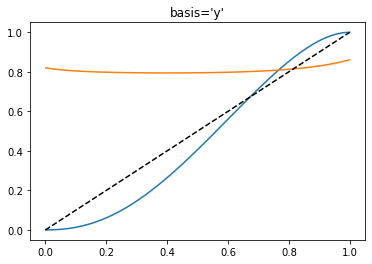

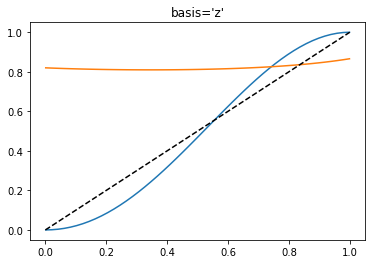

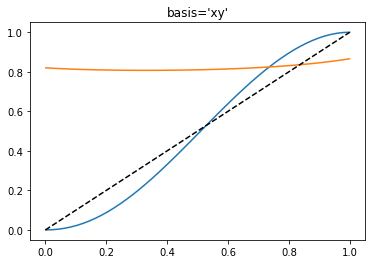

In [13]:
noise = 0.2
r5_2l_ec = CascadeDecoder(g2)
for basis in ['spc', 'x', 'y', 'z', 'xy']:
    r5_2l_ec.build_tree(basis, ec=True, cascading=False)

    p1, p2 = [], []
    for trans in transmissions:
        lt_suc, ec_suc = r5_2l_ec.success_prob_outcome_list(trans, noise, basis)
        p1.append(lt_suc)
        p2.append(ec_suc)
    plt.plot(transmissions, p1)
    plt.plot(transmissions, p2)
    plt.plot((0, 1), (0, 1), 'k--')
    plt.title(f'{basis=}')
    plt.show()

There is some weird behaviour with the pauli error rates decreasing slightly at low transmission rates - this is unexpected behaviour

Notice that the effective x measurement probability is particularly good for the 5 ring with 2 leaves

Cascading

To calculate the effect of cascading graphs we need to find their performance to all basis effective measurements, as well as their spc performance.
Then create a AnalyticCascadedResult object, which can calculate the properties of the cascaded graph.
Error correction in cascaded graphs is not yet implemented. For the 5 qubit ring:


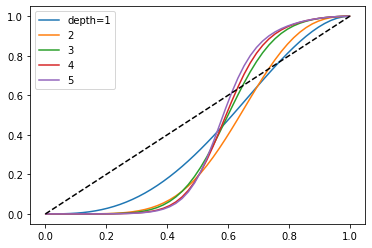

In [16]:
from cascaded import AnalyticCascadedResult
r5_performance_dictionaries = [r5.get_dict(b, ec=False, rebuild_tree=True, cascading=True) for b in ['spc', 'x', 'y', 'z', 'xy']]
r = AnalyticCascadedResult([r5_performance_dictionaries], [0] * 5)
for depth in (1, 2, 3,4, 5):
    log_trans = [r.get_spc_prob(t, depth) for t in transmissions]
    plt.plot(transmissions, log_trans)
plt.plot((0, 1), (0, 1), 'k--')
plt.legend(['depth=1', '2', '3', '4', '5'])
plt.show()



We can also look at how the 5 qubit ring performs under concatenation



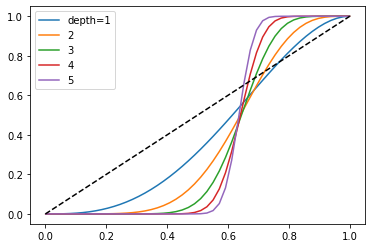

In [18]:
from cascaded import ConcatenatedResultDicts
res_concatenated = ConcatenatedResultDicts([r5_performance_dictionaries], [0] * 5)
for depth in reversed(list(range(5))):
    log_trans = [res_concatenated.meff_prob(t, depth=depth, basis='spc') for t in transmissions]
    plt.plot(transmissions, log_trans)
plt.plot((0, 1), (0, 1), 'k--')
plt.legend(['depth=1', '2', '3', '4', '5'])
plt.show()